In [31]:
!pip install docplex
!pip install cplex

In [37]:
import numpy as np
import time
import docplex.mp.model as md
import networkx as nx
import matplotlib.pyplot as plt
import random
from random import randint
from scipy.spatial import Delaunay

We want to color nodes of a graph such that adjacent nodes are coloed differently. Let there be $N$ nodes and let the $ith$ node be denoted by the first index in $x_{ij}$. Let there be $K$ colors and let the colors be denoted by the second index $j$ in $x_{ij}$.

We require that (1) each node receives one color and (2) no two adjacent nodes are colored the same. The first condition we have seen before. The second conditon will read $$ x_{ik} + x_{jk} \leq 1$$ where $k = 1, \dots, K$ denotes that no two adjacent nodes are assigned the same color, i.e. we want one node to have at least the color $k$, but we do not want both nodes to have the same color $k$. We also do not care if they have color $k$ or another color, so let us normalize the penalty for $ x_{ik} + x_{ik} =   0,1 \to 0.5$ by writing,

The Hamiltonian becomes $$ H =  A\underbrace{\sum_{i=1}^N \left( \sum_{j=1}^K x_{ij} -1 \right)^2}_{\text{every node $i$  gets assigned one color $j$}}  +  B \underbrace{\sum_{(i,j) \in E} \sum_{k=1}^K \left( (x_{ik} + x_{jk}) -0.5 \right)^2}_{\text{adjacent nodes $i,j$ do not get assigned the same color $k$}}$$

In [38]:
nodes, colors, A, B = 10, 4, 10000, 10
# Create Nodes
np.random.seed(0)
x_coord = np.random.randint(0,100,nodes)
np.random.seed(1)
y_coord = np.random.randint(0,100,nodes)
points=[]
for i in range(nodes):
    points.append((x_coord[i],y_coord[i]))

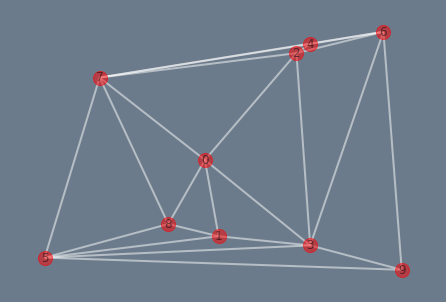

In [39]:
# Generate Graph With Nodes and Edges
G_d = nx.Graph()
for i in range(nodes): 
    G_d.add_node(i,pos=points[i])
edges_d=[]
tri = Delaunay(points)
for i in range(len(tri.simplices)):
    for j in range(3):
        edges_d.append((tri.simplices[i][j],tri.simplices[i][j+1]) if j!=2 else (tri.simplices[i][j],tri.simplices[i][0]))
G_d.add_edges_from(edges_d)
# Create a new array with explicit edges copied from G.edges as edges
# has duplicates and is out of order
new_edges=[]
for i,j in G_d.edges:
  new_edges.append((i,j))
fig = plt.figure()
nx.draw(G_d, pos=nx.get_node_attributes(G_d,'pos'), with_labels=True, alpha=0.5, node_color='red', edge_color='w',width=2.0,node_size=200)
fig.set_facecolor("#6C7B8B")

In [40]:
color=md.Model(name='Graph_Coloring')
x=np.array(color.binary_var_list(nodes*colors)).reshape(nodes,colors)
H1 = A*np.sum([ [ (np.sum(x[i,:])-1)**2 ] for i in range(nodes)])
H2 = B*np.sum([ [ ((x[i,k]+x[j,k])-0.5)**2 ] for k in range(colors) for i,j in G_d.edges ])
color.minimize(H1+H2)
solution = np.array(color.solve().get_value_list(x.flatten())).reshape(nodes,colors)
print(solution)

[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


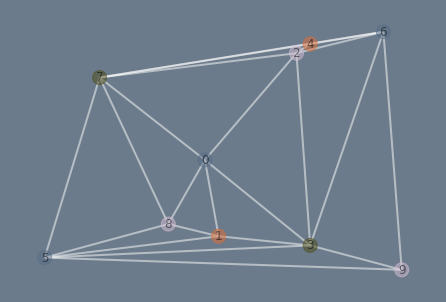

In [41]:
# Plot Solution
# Generate Graph With Nodes and Edges
G2_d = nx.Graph()
c = []
for i in range(colors):
  c.append('#%06X' % randint(0, 0xFFFFFF))

for i in range(nodes): 
  for j in range(colors):
    if solution[i,j]==1:
        G2_d.add_node(i,pos=points[i],color=c[j])
  
colors = [node[1]['color'] for node in G2_d.nodes(data=True)]
G2_d.add_edges_from(new_edges)
fig2 = plt.figure()
nx.draw(G2_d, pos=nx.get_node_attributes(G2_d,'pos'), with_labels=True, node_color=colors, edge_color='w', width=2.0,alpha=0.5, node_size=200)
fig2.set_facecolor("#6C7B8B")